In [1]:
%matplotlib inline
import os
os.environ['THEANO_FLAGS']='device=gpu0'

import matplotlib
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import lasagne
import theano
import theano.tensor as T
conv = lasagne.layers.Conv2DLayer
pool = lasagne.layers.MaxPool2DLayer

from lasagne.utils import as_tuple, floatX
from lasagne.random import get_rng
import cv2

NUM_EPOCHS = 101
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"
#INPUT FILE DEGISTIRILECEK

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
class TransformerLayer(lasagne.layers.MergeLayer):
    """
    Spatial transformer layer
    The layer applies an affine transformation on the input. The affine
    transformation is parameterized with six learned parameters [1]_.
    The output is interpolated with a bilinear transformation.
    Parameters
    ----------
    incoming : a :class:`Layer` instance or a tuple
        The layer feeding into this layer, or the expected input shape. The
        output of this layer should be a 4D tensor, with shape
        ``(batch_size, num_input_channels, input_rows, input_columns)``.
    localization_network : a :class:`Layer` instance
        The network that calculates the parameters of the affine
        transformation. See the example for how to initialize to the identity
        transform.
    downsample_factor : float or iterable of float
        A float or a 2-element tuple specifying the downsample factor for the
        output image (in both spatial dimensions). A value of 1 will keep the
        original size of the input. Values larger than 1 will downsample the
        input. Values below 1 will upsample the input.
    References
    ----------
    .. [1]  Max Jaderberg, Karen Simonyan, Andrew Zisserman,
            Koray Kavukcuoglu (2015):
            Spatial Transformer Networks. NIPS 2015,
            http://papers.nips.cc/paper/5854-spatial-transformer-networks.pdf
    Examples
    --------
    Here we set up the layer to initially do the identity transform, similarly
    to [1]_. Note that you will want to use a localization with linear output.
    If the output from the localization networks is [t1, t2, t3, t4, t5, t6]
    then t1 and t5 determines zoom, t2 and t4 determines skewness, and t3 and
    t6 move the center position.
    >>> import numpy as np
    >>> import lasagne
    >>> b = np.zeros((2, 3), dtype='float32')
    >>> b[0, 0] = 1
    >>> b[1, 1] = 1
    >>> b = b.flatten()  # identity transform
    >>> W = lasagne.init.Constant(0.0)
    >>> l_in = lasagne.layers.InputLayer((None, 3, 28, 28))
    >>> l_loc = lasagne.layers.DenseLayer(l_in, num_units=6, W=W, b=b,
    ... nonlinearity=None)
    >>> l_trans = lasagne.layers.TransformerLayer(l_in, l_loc)
    """
    def __init__(self, incoming, localization_network, downsample_factor=1,
                 **kwargs):
        super(TransformerLayer, self).__init__(
            [incoming, localization_network], **kwargs)
        self.downsample_factor = as_tuple(downsample_factor, 2)

        input_shp, loc_shp = self.input_shapes

        if loc_shp[-1] != 6 or len(loc_shp) != 2:
            raise ValueError("The localization network must have "
                             "output shape: (batch_size, 6)")
        if len(input_shp) != 4:
            raise ValueError("The input network must have a 4-dimensional "
                             "output shape: (batch_size, num_input_channels, "
                             "input_rows, input_columns)")

    def get_output_shape_for(self, input_shapes):
        shape = input_shapes[0]
        factors = self.downsample_factor
        return (shape[:2] + tuple(None if s is None else int(s // f)
                                  for s, f in zip(shape[2:], factors)))

    def get_output_for(self, inputs, **kwargs):
        # see eq. (1) and sec 3.1 in [1]
        input, theta = inputs
        self.x, self.y = _transform_affine(theta, input, self.downsample_factor)
        return self.x
    
def _meshgrid(height, width):
    # This function is the grid generator from eq. (1) in reference [1].
    # It is equivalent to the following numpy code:
    #  x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
    #                         np.linspace(-1, 1, height))
    #  ones = np.ones(np.prod(x_t.shape))
    #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
    # It is implemented in Theano instead to support symbolic grid sizes.
    # Note: If the image size is known at layer construction time, we could
    # compute the meshgrid offline in numpy instead of doing it dynamically
    # in Theano. However, it hardly affected performance when we tried.
    x_t = T.dot(T.ones((height, 1)),
                _linspace(-1.0, 1.0, width).dimshuffle('x', 0))
    y_t = T.dot(_linspace(-1.0, 1.0, height).dimshuffle(0, 'x'),
                T.ones((1, width)))

    x_t_flat = x_t.reshape((1, -1))
    y_t_flat = y_t.reshape((1, -1))
    ones = T.ones_like(x_t_flat)
    grid = T.concatenate([x_t_flat, y_t_flat, ones], axis=0)
    return grid
    
def _transform_affine(theta, input, downsample_factor):
    num_batch, num_channels, height, width = input.shape
    theta = T.reshape(theta, (-1, 2, 3))
    
    # grid of (x_t, y_t, 1), eq (1) in ref [1]
    out_height = T.cast(height // downsample_factor[0], 'int64')
    out_width = T.cast(width // downsample_factor[1], 'int64')
    grid = _meshgrid(out_height, out_width)

    # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
    T_g = T.dot(theta, grid)
    x_s = T_g[:, 0]
    y_s = T_g[:, 1]
    x_s_flat = x_s.flatten()
    y_s_flat = y_s.flatten()
    
    #BEGINNING OF EDITED SECTION

#     print theta.dim
#     print x_s_flat.ndim
#     print y_s_flat.ndim
    
#     x_s_flat = x_s_flat - theta[2]
#     y_s_flat = y_s_flat - theta[5]
    
#     THETA = np.array([theta[:,0], theta[:,1]] [theta[:,3], theta[:,4]])
#     x_s_flat, y_s_flat = numpy.linalg.inv(THETA)*np.array(x_s_flat, y_s_flat)
    #END OF EDITED SECTION

    # dimshuffle input to  (bs, height, width, channels)
    input_dim = input.dimshuffle(0, 2, 3, 1)
    input_transformed = _interpolate(
        input_dim, x_s_flat, y_s_flat,
        out_height, out_width)

    output = T.reshape(
        input_transformed, (num_batch, out_height, out_width, num_channels))
    output = output.dimshuffle(0, 3, 1, 2)  # dimshuffle to conv format
    T_g = T.reshape(input_transformed, (num_batch, out_height, out_width, num_channels))
    return output, T_g
#OUTPUT: T_g and grid is also included.

def _linspace(start, stop, num):
    # Theano linspace. Behaves similar to np.linspace
    start = T.cast(start, theano.config.floatX)
    stop = T.cast(stop, theano.config.floatX)
    num = T.cast(num, theano.config.floatX)
    step = (stop-start)/(num-1)
    return T.arange(num, dtype=theano.config.floatX)*step+start

def _interpolate(im, x, y, out_height, out_width):
    # *_f are floats
    num_batch, height, width, channels = im.shape
    height_f = T.cast(height, theano.config.floatX)
    width_f = T.cast(width, theano.config.floatX)

    # clip coordinates to [-1, 1]
    x = T.clip(x, -1, 1)
    y = T.clip(y, -1, 1)

    # scale coordinates from [-1, 1] to [0, width/height - 1]
    x = (x + 1) / 2 * (width_f - 1)
    y = (y + 1) / 2 * (height_f - 1)

    # obtain indices of the 2x2 pixel neighborhood surrounding the coordinates;
    # we need those in floatX for interpolation and in int64 for indexing. for
    # indexing, we need to take care they do not extend past the image.
    x0_f = T.floor(x)
    y0_f = T.floor(y)
    x1_f = x0_f + 1
    y1_f = y0_f + 1
    x0 = T.cast(x0_f, 'int64')
    y0 = T.cast(y0_f, 'int64')
    x1 = T.cast(T.minimum(x1_f, width_f - 1), 'int64')
    y1 = T.cast(T.minimum(y1_f, height_f - 1), 'int64')

    # The input is [num_batch, height, width, channels]. We do the lookup in
    # the flattened input, i.e [num_batch*height*width, channels]. We need
    # to offset all indices to match the flat version
    dim2 = width
    dim1 = width*height
    base = T.repeat(
        T.arange(num_batch, dtype='int64')*dim1, out_height*out_width)
    base_y0 = base + y0*dim2
    base_y1 = base + y1*dim2
    idx_a = base_y0 + x0
    idx_b = base_y1 + x0
    idx_c = base_y0 + x1
    idx_d = base_y1 + x1

    # use indices to lookup pixels for all samples
    im_flat = im.reshape((-1, channels))
    Ia = im_flat[idx_a]
    Ib = im_flat[idx_b]
    Ic = im_flat[idx_c]
    Id = im_flat[idx_d]

    # calculate interpolated values
    wa = ((x1_f-x) * (y1_f-y)).dimshuffle(0, 'x')
    wb = ((x1_f-x) * (y-y0_f)).dimshuffle(0, 'x')
    wc = ((x-x0_f) * (y1_f-y)).dimshuffle(0, 'x')
    wd = ((x-x0_f) * (y-y0_f)).dimshuffle(0, 'x')
    output = T.sum([wa*Ia, wb*Ib, wc*Ic, wd*Id], axis=0)
    return output

In [3]:
import theano
import theano.tensor

x = (_meshgrid(20, 20).shape)

# concrete_x = np.array([[1, 2, 3], [4, 5, 6]], dtype=np.int32)

# x = theano.tensor.imatrix()
# print x.shape.eval({x: concrete_x})
print theano.function(inputs=[], outputs=x.shape)
# print concrete_x.shape

In [4]:
import time
# PARAMETERS
t_start = time.time()
test_dir = "/home/dontgetdown/Documents/caner_grad/MNIST_IMAGES/10_45_90_derece/10k_10k_test"
train_dir = "/home/dontgetdown/Documents/caner_grad/MNIST_IMAGES/10_45_90_derece/50k_50k_train"
out_file = "mnist_cluttered_60x60_45_90degree_rotations.npz"
train_k = 5
valid_k = 1
n_classes = 10
DIM = 60

#COMMENTING STARTS IF THE FILE ALREADY EXISTS

# test_file = open(test_dir, "r")
# train_file = open(train_dir, "r")

# test_file_lines = test_file.readlines()
# test_images_loc = []
# test_classes_pre = []
# test_images_loc.append([test_file_lines[i].split(" ")[0] for i in range(len(test_file_lines))])
# test_classes_pre.append([test_file_lines[i].split(" ")[1] for i in range(len(test_file_lines))])

# trainandvalid_file_lines = train_file.readlines()
# tv_size = len(trainandvalid_file_lines) 
# test_size = len(test_file_lines)

# test_file.close()
# train_file.close()

# trainandvalid_images_loc = []
# trainandvalid_classes_pre = []
# trainandvalid_images_loc.append([trainandvalid_file_lines[i].split(" ")[0] for i in range(tv_size)])
# trainandvalid_classes_pre.append([trainandvalid_file_lines[i].split(" ")[1] for i in range(tv_size)])

# permuted_indexes = np.random.permutation(np.arange(len(trainandvalid_file_lines)))
# train_indexes = permuted_indexes[:tv_size*train_k/(train_k+valid_k)]
# valid_indexes = permuted_indexes[tv_size*train_k/(train_k+valid_k):tv_size]
    
# valid_classes_list = []
# for i in xrange(tv_size*valid_k/(train_k+valid_k)):
#     valid_classes_list.append(trainandvalid_classes_pre[0][valid_indexes[i]])

# train_classes_list = []
# for i in xrange(tv_size*train_k/(train_k+valid_k)):
#     train_classes_list.append(trainandvalid_classes_pre[0][train_indexes[i]])
    
# test_classes = np.zeros((test_size, 10), dtype=np.int64)
# for i in xrange(test_size):
#     for j in range(n_classes):
#         if int(test_classes_pre[0][i])==int(j):
#             test_classes[i][j] = 1
             
# train_classes = np.zeros((tv_size*train_k/(valid_k+train_k), 10), dtype=np.int64)
# for i in xrange(tv_size*train_k/(train_k+valid_k)):
#     for j in xrange(n_classes):
#         if(int(j)==int(train_classes_list[i])):
#             train_classes[i][j] = 1 
            
# valid_classes = np.zeros((tv_size*valid_k/(valid_k+train_k), 10), dtype=np.int64)
# for i in xrange(tv_size*valid_k/(train_k+valid_k)):
#     for j in xrange(n_classes):
#         if(int(j)==int(valid_classes_list[i])):
#             valid_classes[i][j] = 1 

# t_cl_end = time.time()
# print t_cl_end - t_start

# test_images = np.zeros((test_size, 1, DIM, DIM), dtype=np.float32)
# train_images = np.zeros((tv_size*train_k/(valid_k+train_k), 1, DIM, DIM), dtype=np.float32)
# valid_images = np.zeros((tv_size*valid_k/(valid_k+train_k), 1, DIM, DIM), dtype=np.float32)

# for i in xrange(test_images.shape[0]):
#     test_images[i] = cv2.imread(test_images_loc[0][i], cv2.IMREAD_GRAYSCALE)

# for i in xrange(train_images.shape[0]):
#     train_images[i] = cv2.imread(trainandvalid_images_loc[0][train_indexes[i]], cv2.IMREAD_GRAYSCALE)
    
# for i in xrange(valid_images.shape[0]):
#     valid_images[i] = cv2.imread(trainandvalid_images_loc[0][valid_indexes[i]], cv2.IMREAD_GRAYSCALE)

# valid_images[:] = (valid_images - 128)/(128+0.0000001)
# test_images[:] = (test_images - 128)/(128+0.0000001)
# train_images[:] = (train_images - 128)/(128+0.0000001)


# dictionary = {'x_train':train_images, 'x_valid':valid_images, 'x_test':test_images, 'y_train':train_classes, 
#               'y_valid':valid_classes, 'y_test':test_classes}

# t_dict_end = time.time()
# print t_dict_end - t_cl_end

# np.savez(out_file, x_train=dictionary['x_train'], y_train=dictionary['y_train'], x_test=dictionary['x_test'], y_test=dictionary['y_test'], x_valid=dictionary['x_valid'], y_valid=dictionary['y_valid']) 
# t_save_end = time.time()
# print t_save_end - t_dict_end 

# COMMENTING END IF THE FILE ALREADY EXISTS

mnist_90_rotated = out_file
# THEN, BY USING A DIFFERENT NUMPY ARRAY DICTIONARY, WE WILL BE LOADING OUR DATA.
def load_data(x):
    data = np.load(x)
    
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    print "Train samples:", X_train.shape
    print "Validation samples:", X_valid.shape
    print "Test samples:", X_test.shape

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        y_train=y_train.astype('int32'),
        X_valid=lasagne.utils.floatX(X_valid),
        y_valid=y_valid.astype('int32'),
        X_test=lasagne.utils.floatX(X_test),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data(mnist_90_rotated)
# print time.time() - t_save_end


Train samples: (150000, 1, 60, 60)
Validation samples: (30000, 1, 60, 60)
Test samples: (30000, 1, 60, 60)


In [5]:
print data['X_valid'][101]
print data['X_train'][101]


[[[-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  ..., 
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]]]
[[[-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  ..., 
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]]]


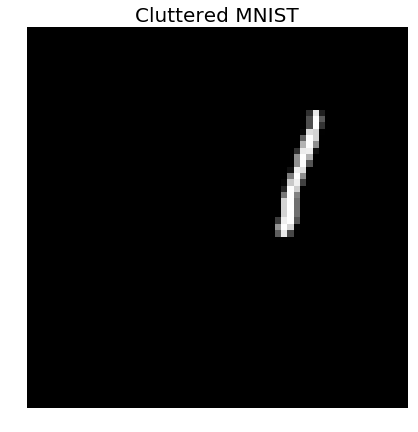

In [110]:
plt.figure(figsize=(7,7))
plt.imshow(data['X_test'][1010].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()


In [7]:
def build_model(input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    ini = lasagne.init.HeUniform()
    l_in = lasagne.layers.InputLayer(shape=(None, 1, input_width, input_height),)

    # Localization network
    b = np.zeros((2, 3), dtype=theano.config.floatX)
    b[0, 0] = 1
    b[1, 1] = 1
    b = b.flatten()
    loc_l1 = pool(l_in, pool_size=(2, 2))
    loc_l2 = conv(
        loc_l1, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l3 = pool(loc_l2, pool_size=(2, 2))
    loc_l4 = conv(loc_l3, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l5 = lasagne.layers.DenseLayer(
        loc_l4, num_units=50, W=lasagne.init.HeUniform('relu'))
    loc_out = lasagne.layers.DenseLayer(
        loc_l5, num_units=6, b=b, W=lasagne.init.Constant(0.0), 
        nonlinearity=lasagne.nonlinearities.identity)
    
    # Transformer network
    l_trans1 = TransformerLayer(l_in, loc_out, downsample_factor=3.0)
    print "Transformer network output shape: ", l_trans1.output_shape
    
    # Classification network
    class_l1 = conv(
        l_trans1,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l2 = pool(class_l1, pool_size=(2, 2))
    class_l3 = conv(
        class_l2,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l4 = pool(class_l3, pool_size=(2, 2))
    class_l5 = lasagne.layers.DenseLayer(
        class_l4,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )

    l_out = lasagne.layers.DenseLayer(
        class_l5,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=ini,
    )

    return l_out, l_trans1, loc_out

model, l_transform, thetas = build_model(DIM, DIM, NUM_CLASSES)
model_params = lasagne.layers.get_all_params(model, trainable=True)


Transformer network output shape:  (None, 1, 20, 20)


In [8]:
X = T.tensor4()
y = T.ivector()

# training output
output_train = lasagne.layers.get_output(model, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval, transform_eval, thetas_tensor = lasagne.layers.get_output([model, l_transform, thetas], X, deterministic=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
cost_test = T.mean(T.nnet.categorical_crossentropy(output_eval, y))
updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

train = theano.function([X, y], [cost, output_train], updates=updates)
eval = theano.function([X, y], [output_eval, transform_eval, thetas_tensor, cost_test])


/usr/local/lib/python2.7/dist-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [10]:
def train_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    loss = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train = train(X_batch, y_batch)
        loss += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)

    return np.mean(loss), correct / float(num_samples)


def eval_epoch(X, y):
    loss = []
    output_eval, transform_eval, actual_thetas, loss = eval(X, y)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return np.mean(loss), acc, transform_eval, actual_thetas, preds, output_eval

print "Done"

Done


In [ ]:
#EDITS SHOULD BE PERFORMED
# BEFORE TRAINING, HOW IS THE ACCURACY LIKE?
# y_test2 = np.array([1, 1, 1, 1, 4, 4, 4, 4, 7, 0, 7, 2, 2, 2, 0, 0, 0, 2, 7, 7, 3, 3, 3, 3, 6, 6, 5, 5, 5, 5, 8, 6, 8, 6, 8, 8, 9, 9, 9, 9], dtype=np.int32)
# X_test2 = np.zeros((y_test2.shape[0], 1, 60, 60), dtype=np.float32)
# for i in range(40):
#     X_test2[i] = cv2.imread("/home/dl2/caner_grad/temp/translated_ones/"+str(i)+ ".png", cv2.IMREAD_GRAYSCALE)
# for i in range(40):    
#     X_test2[i] = (X_test2[i] - np.mean(X_test2[i]))/np.std(X_test2[i])
# test_loss2, test_acc2, test_transform2, actual_thetas2, preds2, output_eval2 = eval_epoch(X_test2, y_test2)
# print "test loss {0}, test acc {1}".format(test_loss2, test_acc2)

In [ ]:
# plt.figure(figsize=(7,28))
# k=20
# for i in range(k):
#     plt.subplot(k,2,1+i*2)
#     plt.imshow(X_test2[i].reshape(DIM, DIM), cmap='gray', interpolation='none')
#     if i == 0:
#         plt.title('Original 60x60', fontsize=20)
#     plt.axis('off')
#     plt.subplot(k,2,2+i*2)
#     plt.imshow(test_transform2[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
#     if i == 0:
#         plt.title('Transformed 20x20', fontsize=20)
#     plt.axis('off')
# plt.tight_layout()


In [ ]:
# SKIP IF ALREADY PRETRAINED
# theano.config.exception_verbosity="high"

# valid_accs, train_accs = [], []
# valid_losses, train_losses = [], []
# test_accs = []
# test_losses = []

# try:
#     for n in range(NUM_EPOCHS):
#         train_loss, train_acc = train_epoch(data['X_train'], data['y_train'])
#         val_loss, valid_acc, valid_trainsform, dummy, preds_valid, output_eval_valid  = eval_epoch(data['X_valid'], data['y_valid'])
#         valid_accs += [valid_acc]
#         train_accs += [train_acc]
#         valid_losses += [val_loss]
#         train_losses += [train_loss]
        
#         if n%10 == 0:
#             np.savez('model'+str(n)+'.npz', *lasagne.layers.get_all_param_values(model))

#         if (n+1) % 20 == 0:
#             new_lr = sh_lr.get_value() * 0.7
#             print "New LR:", new_lr
#             sh_lr.set_value(lasagne.utils.floatX(new_lr))

# #         print "Epoch {0}: Train loss {1}, Train acc {2}, val acc {3}, test acc {4}".format(
# #                 n, train_loss, train_acc, valid_acc, test_acc) 
#         print "Epoch {0}: Train loss {1}, Train acc {2}, val acc {3}".format(
#                 n, train_loss, train_acc, valid_acc)
# #         print "Epoch {0}: Train loss {1}, Train acc {2}".format(
# #                 n, train_loss, train_acc)
# except KeyboardInterrupt:
#     pass


In [11]:
test_accs = []
test_losses = []
preds_train = []

print "Testing session"

theano.config.exception_verbosity="high"
for i in range(11):
    with np.load('6_thetas/model'+str(i*10)+".npz") as f:
         param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(model, param_values)
    test_loss, test_acc, test_transform, actual_thetas, preds, output_eval = eval_epoch(data['X_test'][:], data['y_test'][:])
    test_accs += [test_acc]
    test_losses += [test_loss]
    preds_train += [np.argmax(output_eval, axis=-1)]



Testing session


In [12]:
#TEST ACC & LOSS FOR MODELS 
print test_losses
print test_accs

[0.32056159, 0.064431168, 0.041286718, 0.050997157, 0.041102294, 0.044836067, 0.04174789, 0.050766777, 0.0459208, 0.05030885, 0.054118395]
[0.89906666666666668, 0.9785666666666667, 0.98683333333333334, 0.98516666666666663, 0.98896666666666666, 0.98866666666666669, 0.99003333333333332, 0.98926666666666663, 0.99086666666666667, 0.99013333333333331, 0.98950000000000005]


In [13]:
#VALID ACC & LOSS FOR MODELS
print test_losses
print test_accs

[0.32056159, 0.064431168, 0.041286718, 0.050997157, 0.041102294, 0.044836067, 0.04174789, 0.050766777, 0.0459208, 0.05030885, 0.054118395]
[0.89906666666666668, 0.9785666666666667, 0.98683333333333334, 0.98516666666666663, 0.98896666666666666, 0.98866666666666669, 0.99003333333333332, 0.98926666666666663, 0.99086666666666667, 0.99013333333333331, 0.98950000000000005]


NameError: name 'train_accs' is not defined

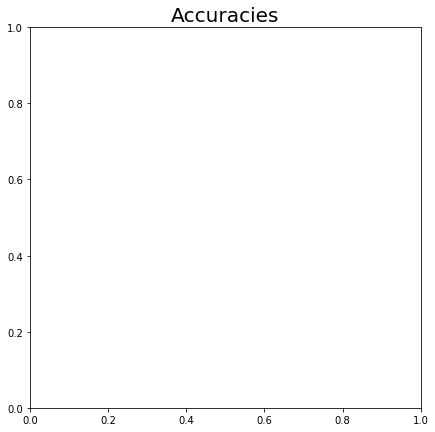

In [13]:
plt.figure(figsize=(7,7))
plt.title('Accuracies', fontsize=20)
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.plot(1-np.array(test_accs), label='Testing Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

plt.figure(figsize=(7,7))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
plt.plot(range(len(test_losses)), test_losses, label='Testing Loss')
plt.xlabel('Epoch', fontsize=20)
plt.legend(fontsize=20)
plt.title('Train Loss', fontsize=20)
plt.show()


In [ ]:
print data['X_train'][1].shape

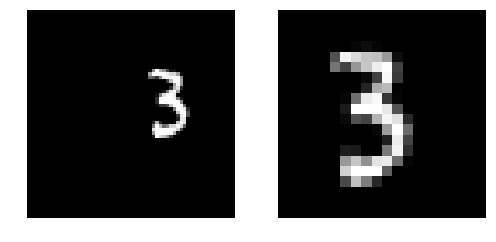

In [13]:
plt.figure(figsize=(7,14))
k=1
l = 3305
for i in [l+j for j in range(k)]:
    plt.subplot(k,2,1+(i-l)*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(k,2,2+(i-l)*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
plt.tight_layout()


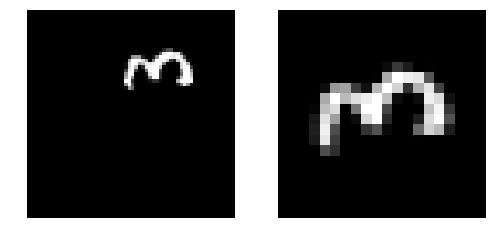

In [14]:
plt.figure(figsize=(7,14))
k=1
l = 13305
for i in [l+j for j in range(k)]:
    plt.subplot(k,2,1+(i-l)*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(k,2,2+(i-l)*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
plt.tight_layout()


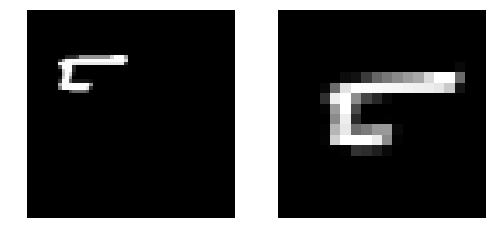

In [13]:
plt.figure(figsize=(7,14))
k=1
l = 17000
for i in [l+j for j in range(k)]:
    plt.subplot(k,2,1+(i-l)*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(k,2,2+(i-l)*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
plt.tight_layout()

In [ ]:
r_theta = (lambda theta: np.array([[1, 0, 0 ], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]]))
r_fi = (lambda fi: np.array([[np.cos(fi), 0, np.sin(fi)], [0, 1, 0], [-np.sin(fi), 0, np.cos(fi)]]))
r_phi = (lambda phi: np.array([[np.cos(phi), -np.sin(phi), 0], [np.sin(phi), np.cos(phi), 0], [0, 0, 1]]))

#print r_phi(50)*r_fi(45)*r_theta(15)
klm = lambda theta, fi, phi:np.array([[1, 0, 0 ], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])*np.array([[np.cos(fi), 0, np.sin(fi)], [0, 1, 0], [-np.sin(fi), 0, np.cos(fi)]])*np.array([[np.cos(phi), -np.sin(phi), 0], [np.sin(phi), np.cos(phi), 0], [0, 0, 1]])

In [14]:
def matrix_to_params(inputs):
    translation_x, translation_y = inputs[2], inputs[5]
    temp_matrix = [[inputs[0], inputs[1]], [inputs[3], inputs[4]]]
    angle = np.arctan(temp_matrix[1][0]/temp_matrix[0][0])
    angle2 = np.arctan(-temp_matrix[0][1]/temp_matrix[1][1])
    scale_x = inputs[0]/np.cos(angle)
    scale_y = inputs[4]/np.cos(angle)
    return scale_x, scale_y, angle*180, angle2*180, translation_x, translation_y
print (actual_thetas[3305:3305+k])
print actual_thetas[13305:13305+k]
print (actual_thetas[17000:17000+k])

threshold = 0.00
sec_param = actual_thetas[:,1]
print sec_param
x = []
for i in xrange(30000):
    if(np.abs(sec_param[i])>threshold):
        x+=[sec_param[i]]        
min_rate = np.min(x)

i = 0
for i in xrange(30000):
    if min_rate == sec_param[i]:
        min_enum = i
print min_enum
print actual_thetas[min_enum]
print np.arctan(-0.03630979/0.52907753)*180 

print 23305
print actual_thetas[23305]

print 13305
print actual_thetas[13305]



[[ 0.50467253 -0.01581604  0.42394128  0.04846202  0.49830046 -0.10282333]]
[[ 0.50512022 -0.01683337  0.27006099  0.0443212   0.50553226 -0.40476274]]
[[ 0.49880707 -0.01644314 -0.43477911  0.04059394  0.50751305 -0.38101694]]
[-0.01824819 -0.02044828 -0.01696042 ..., -0.02208564 -0.01424192
 -0.02112924]
28440
[ 0.52907753 -0.03630979 -0.53117764  0.02755881  0.53859097  0.50561893]
-12.333788278
23305
[ 0.52301472 -0.01852568 -0.26683792  0.03304233  0.52292573  0.27231303]
13305
[ 0.50512022 -0.01683337  0.27006099  0.0443212   0.50553226 -0.40476274]


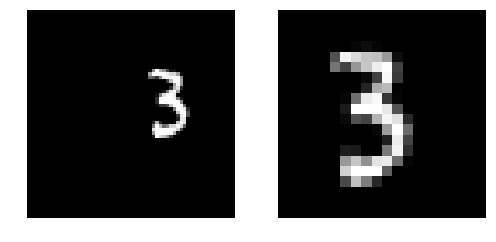

In [15]:
plt.figure(figsize=(7,14))
k=1
l = 3305
for i in [l+j for j in range(k)]:
    plt.subplot(k,2,1+(i-l)*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(k,2,2+(i-l)*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
plt.tight_layout()

(3.0, 3.0)
(1, 3, 60, 60)
(3, 400)
(1, 2, 3)
(1, 2, 400)


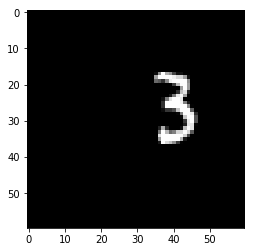

[[0.50467253, -0.01581604, 0.42394128, 0.04846202, 0.49830046, -0.10282333]]
(42.7182384, 26.9153001)


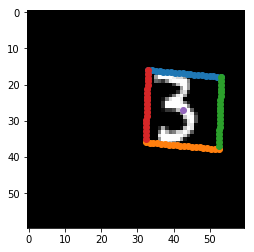

32.308467
15.9800505
53.1280098
37.8505497


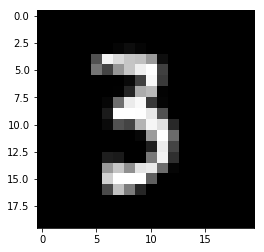

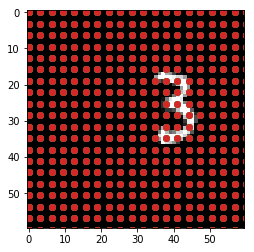

(42.7182384, 26.9153001)
<type 'numpy.ndarray'>
0.44393915


In [109]:
downsample_factor = 3.0
downsample_factor = as_tuple(downsample_factor, 2)
thetas = [[ 0.50467253, -0.01581604,  0.42394128,  0.04846202,  0.49830046, -0.10282333]]


print downsample_factor
def _transform_affine(theta, input, downsample_factor):
    
    num_batch, num_channels, height, width = input.shape
    theta = np.reshape(theta, (-1, 2, 3))
        
    # grid of (x_t, y_t, 1), eq (1) in ref [1]
    out_height = int(height // downsample_factor[0])
    out_width = int(width // downsample_factor[1])
    grid = _meshgrid(out_height, out_width)

    # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
    print grid.shape
    print theta.shape
    T_g = np.dot(theta, grid)
    print T_g.shape
    x_s = T_g[:, 0]
    y_s = T_g[:, 1]
    x_s_flat = x_s.flatten() 
    y_s_flat = y_s.flatten()    
    
    
    #EDITED PART STARTING
#     x_s_flat -= theta[:,0,2]
#     y_s_flat -= theta[:,1,2]
#     print T_g.shape
#     print theta.shape
#     print grid.shape

        
#     THETA = np.array([[theta[:,0,0], theta[:,0,1]], [theta[:,1,0], theta[:,1,1]]]).reshape((2,2))
    
#     temp = np.dot(np.linalg.inv(THETA)[:,:], np.array((x_s_flat, y_s_flat), dtype=np.float32))
    
#     x_s_flat = (temp[0, :])
#     y_s_flat = (temp[1, :])
    
#     out_height = 60
#     out_width = 60
    #EDITED PART ENDING
    # dimshuffle input to  (bs, height, width, channels)
    input_dim = input.transpose(0, 2, 3, 1)

    input_transformed = _interpolate(
        input_dim, x_s_flat, y_s_flat,
        out_height, out_width)
 
    
    output = np.reshape(
        input_transformed, (num_batch, out_height, out_width, num_channels))
    output = output.transpose(0, 3, 1, 2)  # dimshuffle to conv format
    return output, T_g, grid

def _meshgrid(height, width):
    x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
                        np.linspace(-1, 1, height))
    ones = np.ones(np.prod(x_t.shape))
    grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
    return grid

def _interpolate(im, x, y, out_height, out_width):
    num_batch, height, width, channels = im.shape
    height_f = float(height)
    width_f = float(width)
    
    output = np.zeros((out_height*out_width, 1))
    
    for i in xrange(x.shape[0]):
        for n in xrange(height):
            for m in xrange(width):
                temp = im[num_batch-1][n][m][channels-1]
                output[i] += temp*np.maximum(0, 1 - np.abs(x[i]-m))*np.maximum(0, 1 - np.abs(y[i]-n))
    output = np.vstack((output, output, output)).reshape((400,3))

    return output
def _interpolate(im, x, y, out_height, out_width):
    # *_f are floats
    num_batch, height, width, channels = im.shape
    height_f = float(height)
    width_f = float(width)
    
    
    # clip coordinates to [-1, 1]
    x = np.clip(x, -1, 1)
    y = np.clip(y, -1, 1)
    # scale coordinates from [-1, 1] to [0, width/height - 1]
    x = (x + 1) / 2 * (width_f - 1)
    y = (y + 1) / 2 * (height_f - 1)

    # obtain indices of the 2x2 pixel neighborhood surrounding the coordinates;
    # we need those in floatX for interpolation and in int64 for indexing. for
    # indexing, we need to take care they do not extend past the image.
    x0_f = np.floor(x)
    y0_f = np.floor(y)
    
    x1_f = x0_f + 1
    y1_f = y0_f + 1

    x0 = x0_f.astype("int")
    y0 = y0_f.astype("int")
    
    x1 = np.minimum(x1_f, width_f - 1).astype("int")
    y1 = np.minimum(y1_f, height_f - 1).astype("int")

    # The input is [num_batch, height, width, channels]. We do the lookup in
    # the flattened input, i.e [num_batch*height*width, channels]. We need
    # to offset all indices to match the flat version
    dim2 = width
    dim1 = width*height
    base = np.repeat(
        np.arange(num_batch, dtype='int64')*dim1, out_height*out_width)

    base_y0 = base + y0*dim2
    base_y1 = base + y1*dim2
    idx_a = base_y0 + x0
    idx_b = base_y1 + x0
    idx_c = base_y0 + x1
    idx_d = base_y1 + x1

    # use indices to lookup pixels for all samples
    im_flat = im.reshape((-1, channels))
    Ia = im_flat[idx_a]
    Ib = im_flat[idx_b]
    Ic = im_flat[idx_c]
    Id = im_flat[idx_d]
    
    # calculate interpolated values
    wa = np.expand_dims((x1_f-x) * (y1_f-y), 1)
    wb = np.expand_dims((x1_f-x) * (y-y0_f), 1)
    wc = np.expand_dims((x-x0_f) * (y1_f-y), 1)
    wd = np.expand_dims((x-x0_f) * (y-y0_f), 1)
    
    output = np.sum([wa*Ia, wb*Ib, wc*Ic, wd*Id], axis=0)
    return output


test_image = cv2.imread("/home/dontgetdown/Documents/caner_grad/MNIST_IMAGES/45_90_derece/10k+10k_test/3/"+str(3305)+".png")
test_image = np.expand_dims(test_image.transpose(2, 0, 1), 0)
print test_image.shape

out_pic = _transform_affine(thetas, test_image, downsample_factor)

# print out_pic[1]
# plt.imshow(out_pic[0][0].transpose(1,2,0), cmap='gray', interpolation='none')
# # Pick any of the three index, I have chosen 1.
# plt.imshow(out_pic[0][0][1], cmap='gray', interpolation='none')
# plt.show()
# print out_pic[1][0][0]
# print out_pic[1][0][1]
def coordinates (out_pic, thetas, DIM, DIM_prime=DIM/3, *args):
    x_es = DIM/2*out_pic[1][0][0]+DIM/2
    x_es_avg = thetas[0][2]*DIM/2+DIM/2
    x_es_prime = (x_es - x_es_avg)*DIM_prime/(DIM/2) + x_es_avg
    
    y_es = DIM/2*out_pic[1][0][1]+DIM/2
    y_es_avg = thetas[0][5]*DIM/2+DIM/2
    y_es_prime = (y_es - y_es_avg)*DIM_prime/(DIM/2) + y_es_avg

    print (x_es_avg, y_es_avg)
    return x_es_prime, y_es_prime


def scatplotter(DIM, out_pic, thetas, s_ratio):
    print thetas
    x_es, y_es = coordinates(out_pic, thetas, DIM)
    plt.scatter(x_es[0:20], y_es[0:20])
    plt.scatter(x_es[380:400], y_es[380:400])
    plt.scatter(x_es[19:399:20], y_es[19:399:20])
    plt.scatter(x_es[0:380:20], y_es[0:380:20])    
        
    plt.scatter(thetas[0][2]*DIM/2+DIM/2, thetas[0][5]*DIM/2+DIM/2)

#     plt.scatter(x_es, y_es)
    plt.imshow(test_image[0][1], cmap='gray', interpolation='none')
    plt.show()
    
    print x_es.min()
    print y_es.min()
    print x_es.max()
    print y_es.max()
    

def plotter(image):
    plt.imshow(image[0][0][1], cmap='gray', interpolation='none')
    plt.show()

def scatplotter2(DIM, out_pic, thetas, s_ratio):
    x_es = DIM*(out_pic[2][0].flatten()+1)/2
    y_es = DIM*(out_pic[2][1].flatten()+1)/2
#     print x_es
#     print y_es
    
    plt.scatter(x_es[:], y_es[:])
    plt.scatter(x_es[:], y_es[:])
    plt.scatter(x_es[:], y_es[:])
    plt.scatter(x_es[:], y_es[:])
#     plt.scatter(x_es, y_es)
    plt.imshow(test_image[0][1], cmap='gray', interpolation='none')
    plt.show()    
    
DIM = 60

plt.imshow(test_image[0][1], cmap='gray', interpolation='none')
plt.show()
scatplotter(DIM, out_pic, thetas, downsample_factor[0])
plotter(out_pic)
scatplotter2(DIM, out_pic, thetas, downsample_factor[0])
x_es = coordinates(out_pic, thetas, DIM)[0]
print type(x_es)
print np.max( out_pic[1][0][1])

# print x_es
# print y_es

# print np.argmax(x_es, axis=-1)


(1, 3, 60, 60)
(3, 400)
(1, 2, 3)
(1, 2, 400)


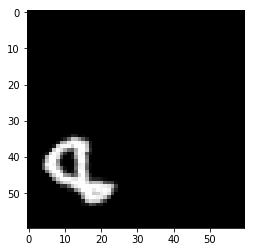

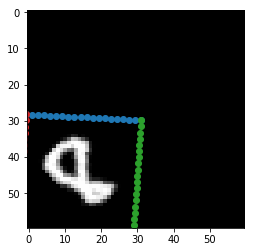

-2.8969488
28.1840745
31.0262904
62.1530613


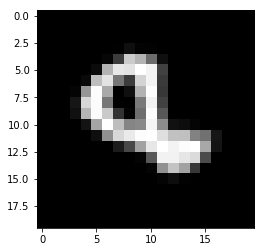

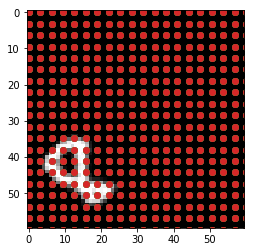

In [21]:
thetas = [[ 0.52907753, -0.03630979, -0.53117764,  0.02755881,  0.53859097,  0.50561893]]

test_image = cv2.imread("/home/dontgetdown/Documents/caner_grad/MNIST_IMAGES/45_90_derece/10k+10k_test/8/"+str(28440)+".png")
test_image = np.expand_dims(test_image.transpose(2, 0, 1), 0)
print test_image.shape

out_pic = _transform_affine(thetas, test_image, downsample_factor)


plt.imshow(test_image[0][1], cmap='gray', interpolation='none')
plt.show()
scatplotter(DIM, out_pic, thetas, downsample_factor[0])
plotter(out_pic)
scatplotter2(DIM, out_pic, thetas, downsample_factor[0])
x_es = coordinates(out_pic, thetas, DIM)[0]

(1, 3, 60, 60)
(3, 400)
(1, 2, 3)
(1, 2, 400)


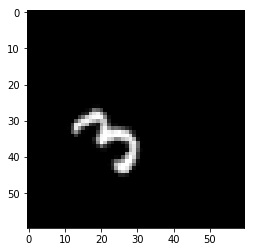

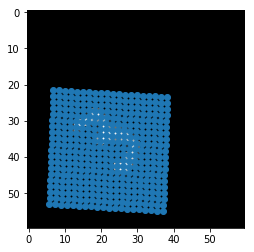

5.7486543
21.4903467
38.2410789
54.8484297


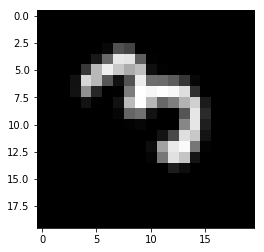

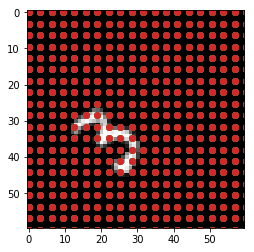

In [26]:
thetas = [[ 0.52301472, -0.01852569, -0.26683778,  0.03304232,  0.52292573,  0.27231294]]

test_image = cv2.imread("/home/dontgetdown/Documents/caner_grad/MNIST_IMAGES/45_90_derece/10k+10k_test/3/"+str(23305)+".png")
test_image = np.expand_dims(test_image.transpose(2, 0, 1), 0)
print test_image.shape

out_pic = _transform_affine(thetas, test_image, downsample_factor)


plt.imshow(test_image[0][1], cmap='gray', interpolation='none')
plt.show()
scatplotter(DIM, out_pic, thetas, downsample_factor[0])
plotter(out_pic)
scatplotter2(DIM, out_pic, thetas, downsample_factor[0])
x_es = coordinates(out_pic, thetas, DIM)[0]

(1, 3, 60, 60)
(3, 400)
(1, 2, 3)
(1, 2, 400)


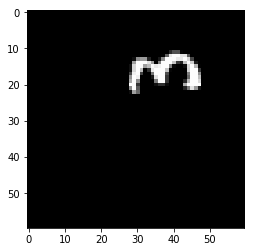

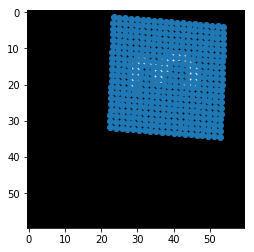

22.4432202
1.3615158
53.7604356
34.3527264


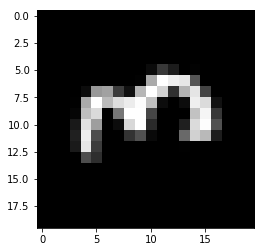

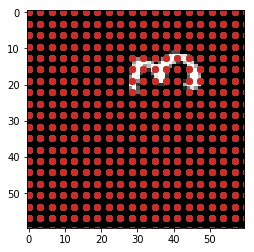

In [29]:
thetas = [[ 0.50512022, -0.01683337,  0.27006093,  0.04432119,  0.50553232, -0.40476263]]

test_image = cv2.imread("/home/dontgetdown/Documents/caner_grad/MNIST_IMAGES/45_90_derece/10k+10k_test/3/"+str(13305)+".png")
test_image = np.expand_dims(test_image.transpose(2, 0, 1), 0)
print test_image.shape

out_pic = _transform_affine(thetas, test_image, downsample_factor)


plt.imshow(test_image[0][1], cmap='gray', interpolation='none')
plt.show()
scatplotter(DIM, out_pic, thetas, downsample_factor[0])
plotter(out_pic)
scatplotter2(DIM, out_pic, thetas, downsample_factor[0])
x_es = coordinates(out_pic, thetas, DIM)[0]

In [ ]:
y_test3 = np.array([1, 1, 1, 1, 4, 4, 4, 4, 7, 0, 7, 2, 2, 2, 0, 0, 0, 2, 7, 7, 3, 3, 3, 3, 6, 6, 5, 5, 5, 5, 8, 6, 8, 6, 8, 8, 9, 9, 9, 9], dtype=np.int32)
X_test3 = np.zeros((y_test3.shape[0], 1, 60, 60), dtype=np.float32)
print y_test3.shape
for i in range(40):
    X_test3[i] = (cv2.imread("/home/dl2/caner_grad/temp/translated_ones/"+str(i)+ ".png", cv2.IMREAD_GRAYSCALE))
mean_target = np.mean(data["X_train"], axis=0)
std_target = np.std(data["X_train"], axis=0)
mean_test = (np.mean(X_test3, axis=0))
std_test = (np.std(X_test3, axis=0))+1e-1/5

X_test3_new = (X_test3 - mean_test + mean_target)/std_test*std_target
print X_test3_new[0]
# print(np.std(X_test3, axis=0))


test_loss3, test_acc3, test_transform3, actual_thetas3, preds3, output_eval3 = eval_epoch(X_test3_new, y_test3)
print "test loss {0}, test acc {1}".format(test_loss3, test_acc3)
print(np.mean(X_test3_new[0]), np.std(X_test3_new[0]))
print(np.mean(data['X_test']), np.std(data['X_test']))


In [ ]:
M = cv2.getRotationMatrix2D((30, 30),90,1)

k=7

y_test3 = data["y_test"][:k].copy()
X_test3 = data["X_test"][:k].copy()
print(X_test3.shape)

for i in range(k):
    a = cv2.warpAffine(np.squeeze(X_test3[i]),M,(60,60))
    X_test3[i] = np.expand_dims(a, 0)
    

test_loss3, test_acc3, test_transform3, actual_thetas3, preds_rot, output_eval3 = eval_epoch(X_test3, y_test3)
print "test loss {0}, test acc {1}".format(test_loss3, test_acc3)
print(np.mean(X_test3[0]), np.std(X_test3[0]))
print(np.mean(data['X_test']), np.std(data['X_test']))
print preds_rot
print actual_thetas3[:8] 
print output_eval3

In [ ]:
plt.figure(figsize=(7,14))
k=7
for i in range(k):
    
    plt.subplot(k,2,1+i*2)
    plt.imshow(X_test3[i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(k,2,2+i*2)
    plt.imshow(test_transform3[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
plt.tight_layout()


In [18]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap              )
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float16') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.around(cm[i, j],decimals = 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[0 0 0 ..., 9 9 9]
Confusion matrix, without normalization
[[2928    0    1    3    0    1    1    2    2    2]
 [   0 3398    2    0    0    0    1    3    1    0]
 [   6    1 3068    6    3    0    0   10    2    0]
 [   0    0    2 3011    0    7    0    4    5    1]
 [   0    0    3    1 2908    2    4    2    1   25]
 [   2    2    0   18    5 2630    9    1    2    7]
 [  14    7    5    3    6   19 2816    1    2    1]
 [   1   10   13    6    4    1    0 3042    1    6]
 [   2    0    7    8    4    1    1    1 2890    8]
 [   1    0    0    3    9    4    2    7    7 2994]]


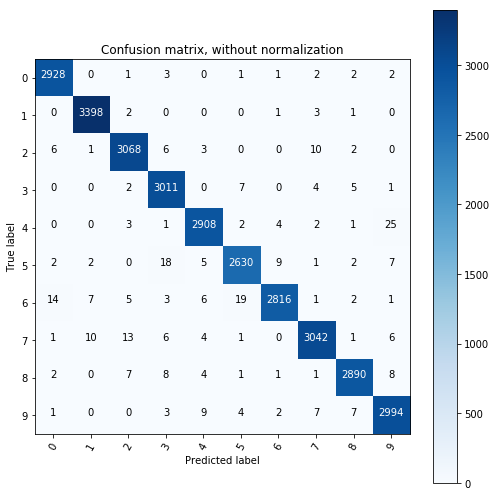

In [21]:
plt.figure(figsize = (7,7))
print np.argmax(output_eval, axis=1)[0:30000]
y_true = data['y_test'][:30000]
y_pred = np.argmax(output_eval, axis=1)[:30000]

cnf_matrix = confusion_matrix(y_true, y_pred)

class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')



Normalized confusion matrix
[[  9.95918367e-01   0.00000000e+00   3.40136054e-04   1.02040816e-03
    0.00000000e+00   3.40136054e-04   3.40136054e-04   6.80272109e-04
    6.80272109e-04   6.80272109e-04]
 [  0.00000000e+00   9.97944200e-01   5.87371512e-04   0.00000000e+00
    0.00000000e+00   0.00000000e+00   2.93685756e-04   8.81057269e-04
    2.93685756e-04   0.00000000e+00]
 [  1.93798450e-03   3.22997416e-04   9.90956072e-01   1.93798450e-03
    9.68992248e-04   0.00000000e+00   0.00000000e+00   3.22997416e-03
    6.45994832e-04   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   6.60066007e-04   9.94059406e-01
    0.00000000e+00   2.31023102e-03   0.00000000e+00   1.32013201e-03
    1.65016502e-03   3.30033003e-04]
 [  0.00000000e+00   0.00000000e+00   1.01832994e-03   3.39443313e-04
    9.87101154e-01   6.78886626e-04   1.35777325e-03   6.78886626e-04
    3.39443313e-04   8.48608282e-03]
 [  7.47384155e-04   7.47384155e-04   0.00000000e+00   6.72645740e-03
    1.86846039e-0

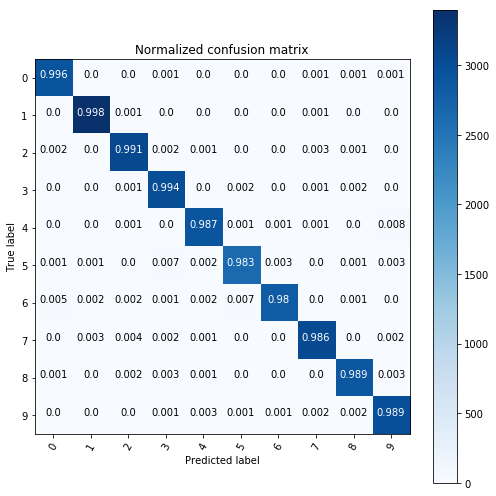

In [22]:
plt.figure(figsize = (7,7))

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')